In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


print('Done.')

Loading data
Done.


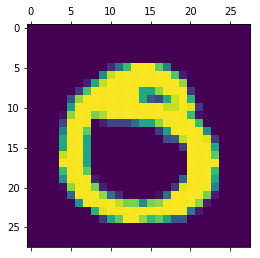

In [4]:
plt.matshow(data_labeled['image'][0, :, :])

In [5]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [6]:
latent_dim = 5
n_classes = 10

In [7]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [14]:
# Load results

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_classifier_final'

enc_file = "../saved_vae_results//mnist_vae_semisuper_enc"
dec_file = '../saved_vae_results/mnist_vae_semisuper_dec'
classifier_file = '../saved_vae_results/mnist_vae_semisuper_classifier'

vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)

In [15]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)>


# Check losses

In [16]:
reinforce_loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae_semisuper_reinforceloss_array.txt')

classic_loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae_semisuperloss_array.txt')

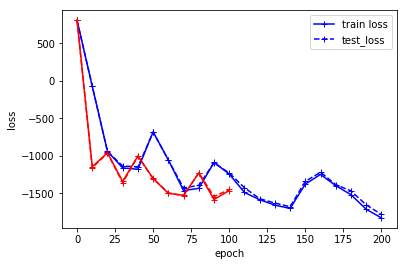

In [17]:
# reinforce losses
plt.plot(reinforce_loss_array[0, :], reinforce_loss_array[1, :], 'b-+')
plt.plot(reinforce_loss_array[0, :], reinforce_loss_array[2, :], 'b--+')

# classic losses
plt.plot(classic_loss_array[0, :], classic_loss_array[1, :], 'r-+')
plt.plot(classic_loss_array[0, :], classic_loss_array[2, :], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [18]:
vae.loss(data_unlabeled['image'])[0]

tensor(-1561.3900)

In [19]:
vae.loss(test_data['image'])[0]

tensor(-1512.9392)

# Look at classification accuracies 

In [20]:
def get_classification_accuracy(loader, classifier, max_images = 1000): 
    n_images = 0.0
    accuracy = 0.0

    for batch_idx, data in enumerate(loader):
        class_weights = vae.classifier(data['image'])

        z_ind = torch.argmax(class_weights, dim = 1)

        accuracy += torch.sum(z_ind == data['label']).float()
        # print(accuracy)

        n_images += len(z_ind)
        if n_images > 1000: 
            break

    return accuracy / n_images

In [21]:
get_classification_accuracy(train_loader_labeled, vae.classifier)

tensor(0.8971)

In [22]:
get_classification_accuracy(train_loader_unlabeled, vae.classifier)

tensor(0.8609)

In [23]:
get_classification_accuracy(test_loader, vae.classifier)

tensor(0.8764)

# Check reconstructions

In [24]:
# These are training images
class_weights = vae.classifier(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

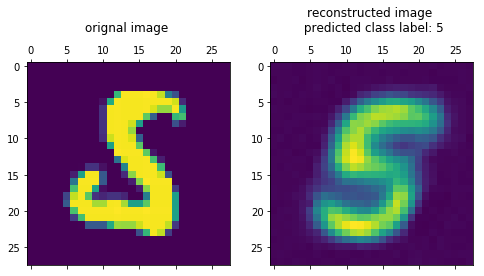

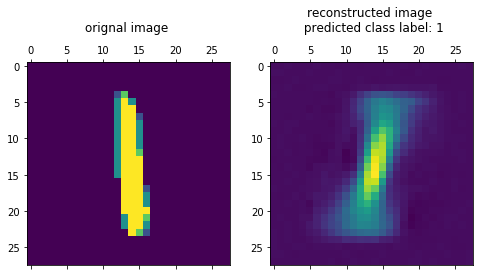

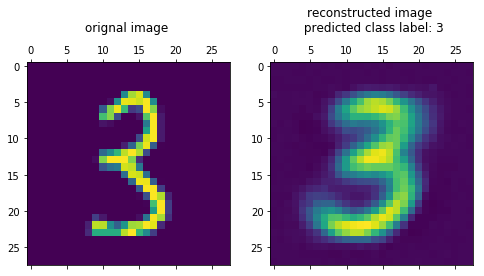

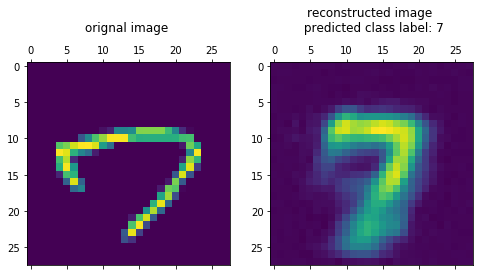

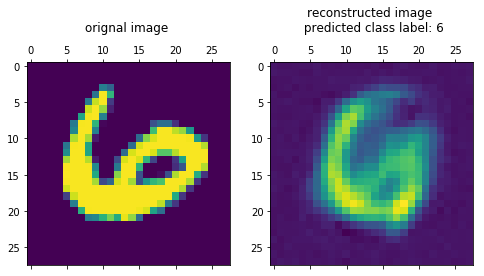

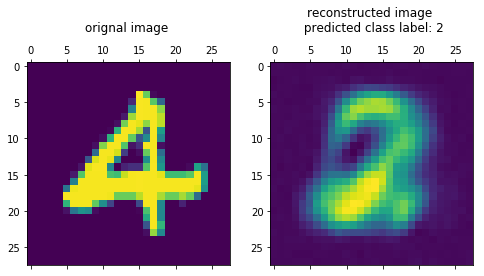

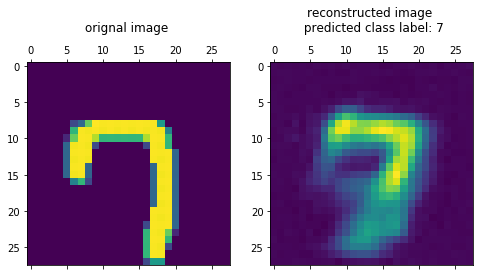

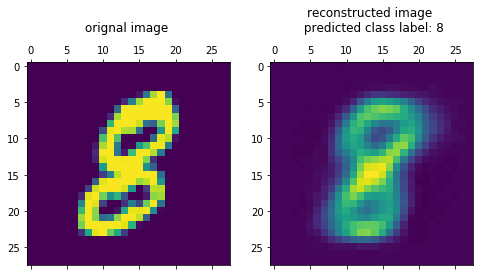

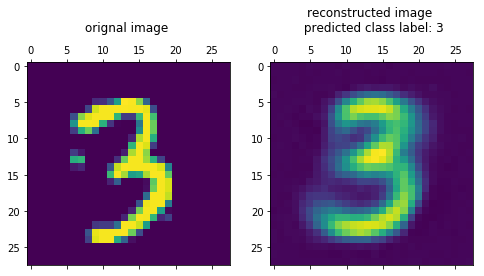

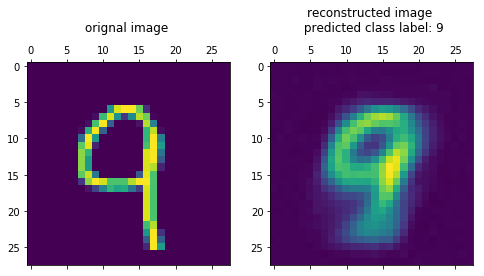

In [25]:
figsize = 8
for i in range(20, 30): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n ')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [26]:
# check a few test images 

In [27]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

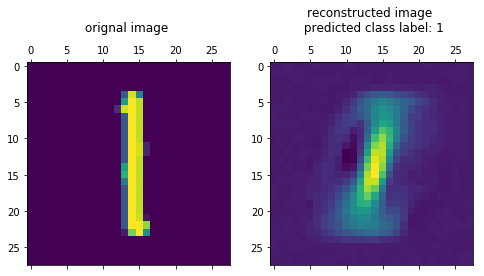

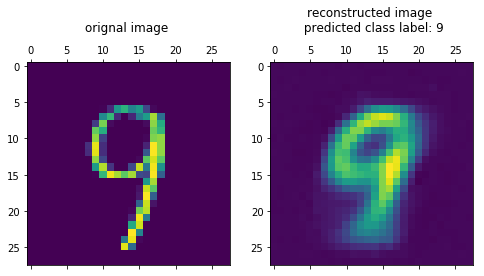

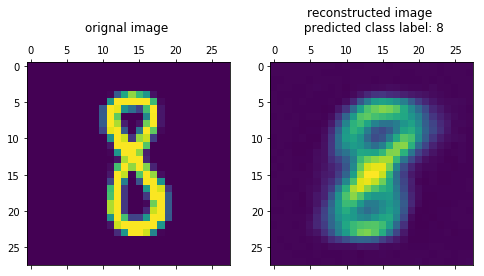

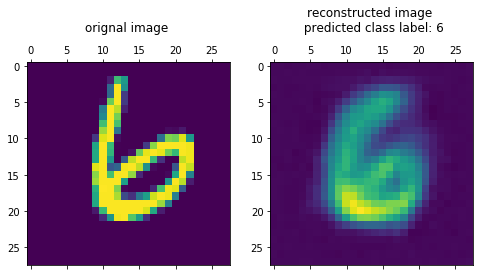

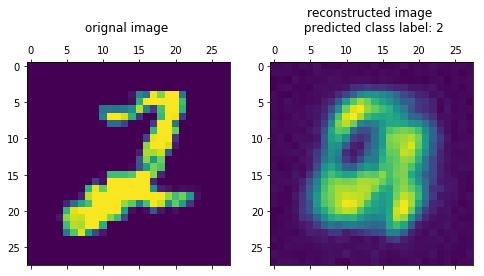

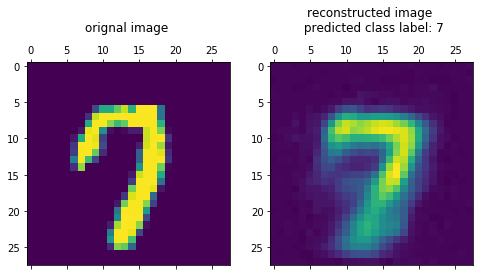

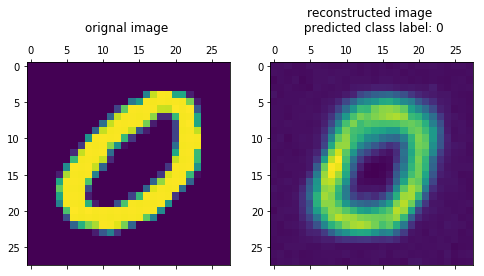

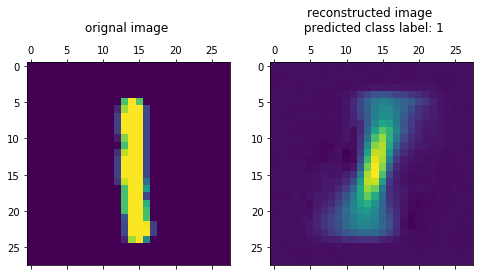

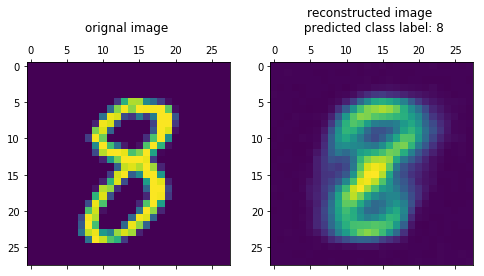

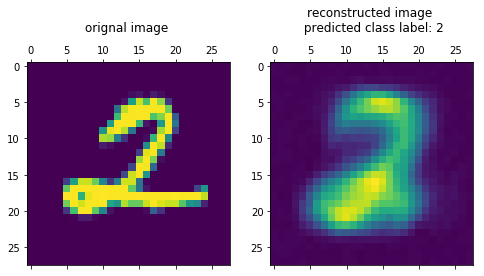

In [28]:
figsize = 8
for i in range(20, 30): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n ')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [23]:
foo = torch.rand((3, 5, 5))
foo_view = foo.view(-1, 25)

In [24]:
for i in range(foo.shape[0]): 
    a = torch.sum(foo[i, :, :] ** 2)
    b = torch.sum(foo[i, :] ** 2)
    print('a: {}, b: {}'.format(a, b))
    assert a == b

a: 8.61171817779541, b: 8.61171817779541
a: 9.121781349182129, b: 9.121781349182129
a: 7.090608596801758, b: 7.090608596801758
